In [2]:
import os
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')


import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



Simulate data. Then check the intrinsic and extrinsic correlations under different conditions

# Reach-Return sim with Correlation Model

## Simulate Data: intrinsic corr = 1

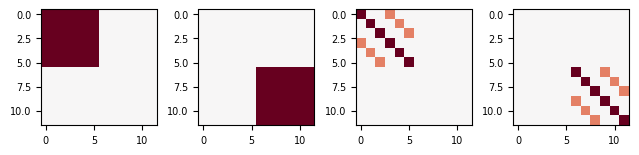

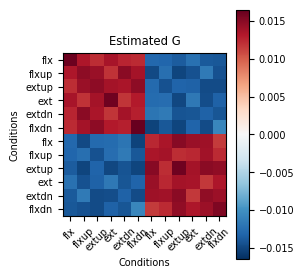

In [27]:
region = 'M1'
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
nsim = 50
signal = [0.01]*nsim
ncond = 12
num_items = 6
# rng = np.random.default_rng(seed=3)
theta=[1,1,0.5,-0.5]

G_mdl = np.eye(num_items)
G_mdl[0,3] = 0.5
G_mdl[1,4] = 0.5
G_mdl[2,5] = 0.5
G_mdl[3,0] = 0.5
G_mdl[4,1] = 0.5
G_mdl[5,2] = 0.5
G_mdl = G_mdl / G_mdl.shape[0]
C = G_mdl
within_cov = C.reshape(1,num_items,num_items)
Mtrue = pcm.CorrelationModel('corr', num_items=num_items, corr=1, cond_effect=True, within_cov=within_cov)

# visualize the model components:
H = Mtrue.n_param
for i in range(H):
    plt.subplot(1, H, i+1)
    vmin = -np.max(np.abs(Mtrue.Gc[i,:,:]))
    vmax = np.max(np.abs(Mtrue.Gc[i,:,:]))
    plt.imshow(Mtrue.Gc[i,:,:], vmin=vmin, vmax=vmax, cmap='RdBu_r')
plt.tight_layout()
plt.show()

cond_vec, part_vec = pcm.sim.make_design(n_cond=12, n_part=10)
D = pcm.sim.make_dataset(model=Mtrue, \
    theta=theta,
    cond_vec=cond_vec,
    part_vec=part_vec,
    n_sim=nsim,
    n_channel=300,
    signal=signal)

# data g matrix:
N = len(D)
G_hat = np.zeros((N, ncond, ncond))
Dist = np.zeros((N,ncond,ncond))
for i in range(N):
    G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                            D[i].obs_descriptors['cond_vec'],
                                            D[i].obs_descriptors['part_vec'],
                                            X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))

# visualize the estimated G:
plt.rcParams.update({'font.size': 7})
G_mean = np.mean(G_hat, axis=0)
plt.figure(figsize=(3,3))
vmin = -np.max(np.abs(G_mean))
vmax = np.max(np.abs(G_mean))
plt.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Estimated G')
plt.xlabel('Conditions')
plt.ylabel('Conditions')
plt.xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
plt.yticks(ticks=np.arange(ncond), labels=labels)
plt.tight_layout()
plt.show()





## pearson r

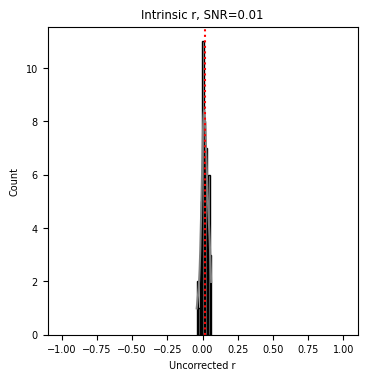

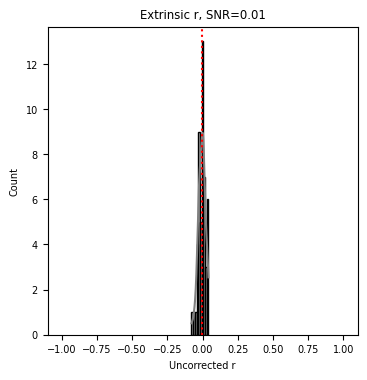

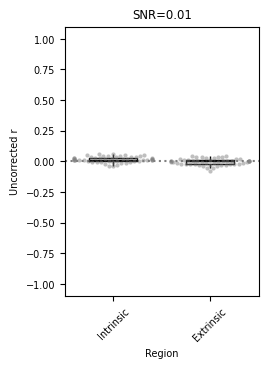

Intrinsic: t=4.60, p=0.0000
Extrinsic: t=-1.26, p=0.2141


In [28]:
intrinsic = [0,1,2,3,4,5, 6,7,8,9,10,11]
r_intrinsic = utils.please.analyze_r(D, intrinsic)
extrinsic = [0,1,2,3,4,5, 9,8,7,6,11,10]
r_extrinsic = utils.please.analyze_r(D, extrinsic)

# distribution of r:
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.histplot(r_intrinsic, kde=True, color='gray', ax=ax, bins=10)
ax.axvline(np.mean(r_intrinsic), color='red', linestyle=':')
ax.set_xlabel('Uncorrected r')
ax.set_ylabel('Count')
ax.set_title(f'Intrinsic r, SNR={signal[0]}')
ax.set_xlim(-1.1,1.1)
plt.show()

fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.histplot(r_extrinsic, kde=True, color='gray', ax=ax, bins=10)
ax.axvline(np.mean(r_extrinsic), color='red', linestyle=':')
ax.set_xlabel('Uncorrected r')
ax.set_ylabel('Count')
ax.set_title(f'Extrinsic r, SNR={signal[0]}')
ax.set_xlim(-1.1,1.1)
plt.show()

df = pd.DataFrame({'r': np.concatenate([r_intrinsic, r_extrinsic]),
                   'region': ['Intrinsic']*len(r_intrinsic) + ['Extrinsic']*len(r_extrinsic)})
# boxplot:
plt.figure(figsize=(2.5,3.5))
plt.axhline(0, color='gray', linestyle=':')
sns.swarmplot(x='region', y='r', data=df, color='gray', size=3, alpha=0.5)
sns.boxplot(x='region', y='r', data=df, width=0.5, color='k', fill=False, showcaps=False, linewidth=1, fliersize=0)
plt.xlabel('Region')
plt.ylabel('Uncorrected r')
plt.title(f'SNR={signal[0]}')
plt.ylim(-1.1,1.1)
# rotate x-tick labels:
plt.xticks(rotation=45)
plt.show()

# significance test vs 0:
t_intrinsic, p_intrinsic = stats.ttest_1samp(r_intrinsic, 0)
t_extrinsic, p_extrinsic = stats.ttest_1samp(r_extrinsic, 0)
print(f'Intrinsic: t={t_intrinsic:.2f}, p={p_intrinsic:.4f}')
print(f'Extrinsic: t={t_extrinsic:.2f}, p={p_extrinsic:.4f}')




## MLE correlation

maxr = 0.543 +/- 0.105
One-sample t-test maxr vs 0: t(49)=5.179; p=0.000004


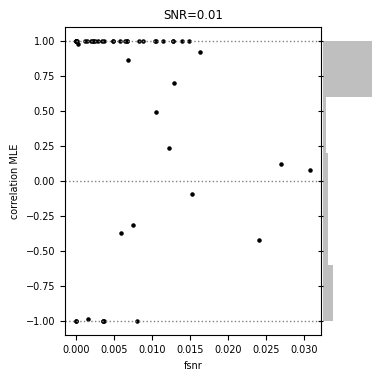

In [ ]:
nsteps = 200 # how many correlation models
M = []

# Generate the models
# for r in np.linspace(-1, 1, nsteps):
#     M.append(pcm.CorrelationModel(f"{r:0.2f}", num_items=6, corr=r, cond_effect=True, within_cov=None))

# Now make the flexible model
Mflex = pcm.CorrelationModel("flex", num_items=6, corr=None, cond_effect=True, within_cov=None)
M.append(Mflex)

T, theta = pcm.fit_model_individ(D, M, fixed_effect='block', fit_scale=False, verbose=False)

# Get the maximum likelihood estimate of each parameter
maxr = M[-1].get_correlation(theta[-1])

# FSNR for flex model:
theta1 = np.exp(theta[-1][2,:])
theta2 = np.exp(theta[-1][3,:])
theta_noise = np.exp(theta[-1][-1,:])
fsnr = np.sqrt(theta1*theta2*10) / theta_noise

from mpl_toolkits.axes_grid1 import make_axes_locatable  # add this import
print(f'maxr = {np.mean(maxr):.3f} +/- {stats.sem(maxr):.3f}')

# t-test maxr vs 0:
t, p = stats.ttest_1samp(maxr, 0, alternative='two-sided')
print(f'One-sample t-test maxr vs 0: t({len(maxr)-1})={t:1.3f}; p={p:1.6f}')

# load results:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.axhline(0, color='gray', linestyle=':', linewidth=1)
ax.axhline(1, color='gray', linestyle=':', linewidth=1)
ax.axhline(-1, color='gray', linestyle=':', linewidth=1)
ax.scatter(fsnr, maxr, color='k', s=5)

# --- vertical marginal histogram of correlation MLE (maxr) ---
divider = make_axes_locatable(ax)
ax_marg = divider.append_axes("right", size="20%", pad=0.02, sharey=ax)
ax_marg.hist(maxr, bins=5, orientation='horizontal', color='gray', alpha=0.5, edgecolor='none')
# clean up marginal axis
ax_marg.set_xticks([])
ax_marg.set_xlabel('')
plt.setp(ax_marg.get_yticklabels(), visible=False)
for spine in ax_marg.spines.values():
    spine.set_visible(False)
# -------------------------------------------------------------

ax.set_xlabel('fsnr')
ax.set_title(f'SNR={signal[0]}')
ax.set_ylabel('correlation MLE')
plt.show()




# Reach-Return sim with Component model

## Simulate Data

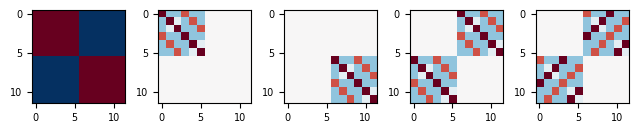

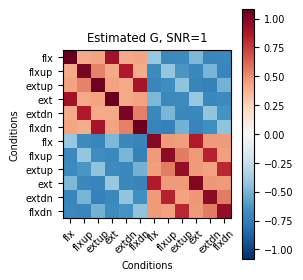

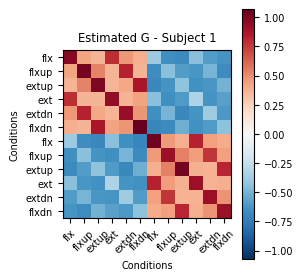

In [47]:
region = 'M1'
file_path = os.path.join(analysisDir, f'pcm_Ghat_best_within_model_{region}.npz')
data = np.load(file_path)
G_mdl = data['G_hat']
G_mdl = G_mdl / np.trace(np.abs(G_mdl))

labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
nsim = 50
signal = [1]*nsim
ncond = 12
num_items = 6
# theta_true = np.array([2,1,0.8,-10e10,0.2]) # extrinsic
theta_true = np.array([2,1,0.8,0.2,-10e10]) # intrinsic

# G_mdl = np.eye(num_items)
# G_mdl[0,3] = 0.5
# G_mdl[1,4] = 0.5
# G_mdl[2,5] = 0.5
# G_mdl[3,0] = 0.5
# G_mdl[4,1] = 0.5
# G_mdl[5,2] = 0.5
# G_mdl = G_mdl / G_mdl.shape[0]

G_model = {}

# hand component:
cov = np.zeros((ncond, ncond))
cov[0:6,0:6] = 1
cov[6:12,6:12] = 1
cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
cov = cov / np.trace(cov)
G_model['hand'] = cov

# contra hand:
C = G_mdl
cov = np.zeros((ncond, ncond))
cov[0:6,0:6] = C
G_model['contra'] = cov

# ipsi hand:
cov = np.zeros((ncond, ncond))
cov[6:12,6:12] = C
G_model['ipsi'] = cov

# intrinsic:
cov = np.zeros((ncond, ncond))
cov[0:6,6:12] = C
cov[6:12,0:6] = C.T
G_model['intrinsic'] = cov

# extrinsic:
cov = np.zeros((ncond, ncond))
C_ext = C[:, [3,2,1,0,5,4]]
cov[0:6,6:12] = C_ext
cov[6:12,0:6] = C_ext.T
G_model['extrinsic'] = cov

Mtrue = pcm.ComponentModel('trueG', [G_model['hand'], G_model['contra'], G_model['ipsi'], G_model['intrinsic'], G_model['extrinsic']])


# visualize the true G:
H = Mtrue.n_param
for i in range(H):
    plt.subplot(1, H, i+1)
    vmin = -np.max(np.abs(Mtrue.Gc[i,:,:]))
    vmax = np.max(np.abs(Mtrue.Gc[i,:,:]))
    plt.imshow(Mtrue.Gc[i,:,:], vmin=vmin, vmax=vmax, cmap='RdBu_r')
plt.tight_layout()
plt.show()

cond_vec, part_vec = pcm.sim.make_design(n_cond=12, n_part=10)
D = pcm.sim.make_dataset(model=Mtrue, \
    theta=theta_true,
    cond_vec=cond_vec,
    part_vec=part_vec,
    n_sim=nsim,
    n_channel=300,
    signal=signal)

# data g matrix:
N = len(D)
G_hat = np.zeros((N, ncond, ncond))
Dist = np.zeros((N,ncond,ncond))
for i in range(N):
    G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                            D[i].obs_descriptors['cond_vec'],
                                            D[i].obs_descriptors['part_vec'],
                                            X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))
    Dist[i,:,:] = pcm.G_to_dist(G_hat[i,:,:])

plt.rcParams.update({'font.size': 7})
# visualize the estimated G:
G_mean = np.mean(G_hat, axis=0)
plt.figure(figsize=(3,3))
vmin = -np.max(np.abs(G_mean))
vmax = np.max(np.abs(G_mean))
plt.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f'Estimated G, SNR={signal[0]}')
plt.xlabel('Conditions')
plt.ylabel('Conditions')
plt.xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
plt.yticks(ticks=np.arange(ncond), labels=labels)
plt.tight_layout()
plt.show()

# visualize subject 1:
G_subj = G_hat[0,:,:]
plt.figure(figsize=(3,3))
vmin = -np.max(np.abs(G_subj))
vmax = np.max(np.abs(G_subj))
plt.imshow(G_subj, cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Estimated G - Subject 1')
plt.xlabel('Conditions')
plt.ylabel('Conditions')
plt.xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
plt.yticks(ticks=np.arange(ncond), labels=labels)
plt.tight_layout()
plt.show()



## Pearson r

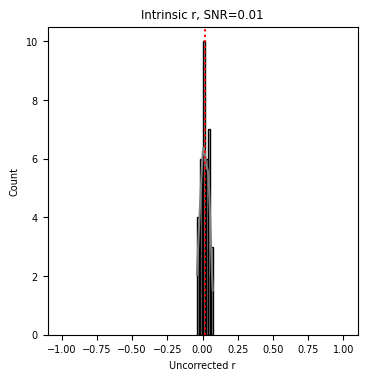

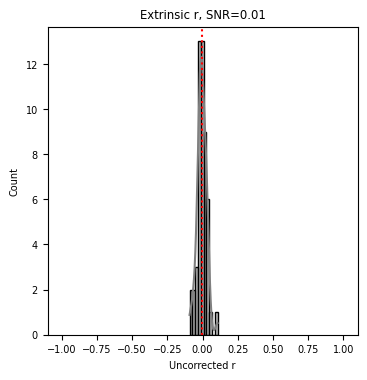

/Users/aghavamp/Desktop/Projects/bimanual_wrist/.conda/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


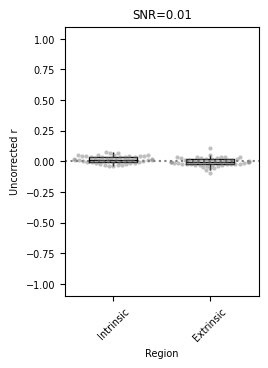

Intrinsic: t=3.62, p=0.0007
Extrinsic: t=-1.01, p=0.3154


In [46]:
specify_conditions = np.array([1,2,4,5])
intrinsic = [0,1,2,3,4,5, 6,7,8,9,10,11]
r_intrinsic = utils.please.analyze_r(D, intrinsic,specify_conditions=specify_conditions)
extrinsic = [0,1,2,3,4,5, 9,8,7,6,11,10]
r_extrinsic = utils.please.analyze_r(D, extrinsic,specify_conditions=specify_conditions)

# distribution of r:
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.histplot(r_intrinsic, kde=True, color='gray', ax=ax, bins=10)
ax.axvline(np.mean(r_intrinsic), color='red', linestyle=':')
ax.set_xlabel('Uncorrected r')
ax.set_ylabel('Count')
ax.set_title(f'Intrinsic r, SNR={signal[0]}')
ax.set_xlim(-1.1,1.1)
plt.show()

fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.histplot(r_extrinsic, kde=True, color='gray', ax=ax, bins=10)
ax.axvline(np.mean(r_extrinsic), color='red', linestyle=':')
ax.set_xlabel('Uncorrected r')
ax.set_ylabel('Count')
ax.set_title(f'Extrinsic r, SNR={signal[0]}')
ax.set_xlim(-1.1,1.1)
plt.show()

df = pd.DataFrame({'r': np.concatenate([r_intrinsic, r_extrinsic]),
                   'region': ['Intrinsic']*len(r_intrinsic) + ['Extrinsic']*len(r_extrinsic)})
# boxplot:
plt.figure(figsize=(2.5,3.5))
plt.axhline(0, color='gray', linestyle=':')
sns.swarmplot(x='region', y='r', data=df, color='gray', size=3, alpha=0.5)
sns.boxplot(x='region', y='r', data=df, width=0.5, color='k', fill=False, showcaps=False, linewidth=1, fliersize=0)
plt.xlabel('Region')
plt.ylabel('Uncorrected r')
plt.title(f'SNR={signal[0]}')
plt.ylim(-1.1,1.1)
# rotate x-tick labels:
plt.xticks(rotation=45)
plt.show()

# significance test vs 0:
t_intrinsic, p_intrinsic = stats.ttest_1samp(r_intrinsic, 0)
t_extrinsic, p_extrinsic = stats.ttest_1samp(r_extrinsic, 0)
print(f'Intrinsic: t={t_intrinsic:.2f}, p={p_intrinsic:.4f}')
print(f'Extrinsic: t={t_extrinsic:.2f}, p={p_extrinsic:.4f}')


